In [2]:
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from utils import market_values

In [3]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [149]:
# counts of number of regions where a generator of e specific carrier is present
n.generators.carrier.value_counts()

onwind                                       181
residential rural solar thermal              181
services rural solar thermal                 181
residential urban decentral solar thermal    181
services urban decentral solar thermal       181
urban central solar thermal                  181
solar                                        178
solar rooftop                                178
offwind-ac                                   100
ror                                           94
offwind-dc                                    69
gas                                            1
oil                                            1
Name: carrier, dtype: int64

In [139]:
carriers = n.generators.carrier.drop_duplicates().tolist()
# carriers = ['offwind-ac','onwind', 'solar','ror','offwind-dc','gas','residential rural solar thermal','services rural solar thermal','residential urban decentral solar thermal','services urban decentral solar thermal','urban central solar thermal','oil','solar rooftop']
# carriers = ['offwind-ac','onwind', 'solar','ror','offwind-dc','solar rooftop']
carriers

['offwind-ac', 'onwind', 'solar', 'ror', 'offwind-dc', 'solar rooftop']

In [145]:
mv_carriers = pd.DataFrame(index = n.buses.location.unique(), columns = carriers)

for carrier in carriers:
    mv_carriers[carrier] = market_values(n, carrier)

mv_carriers

,offwind-ac,onwind,solar,ror,offwind-dc,solar rooftop
AL0 0,126.148417,131.075254,44.628736,NaN,NaN,56.499070
AT0 0,NaN,83.457109,54.679083,87.946522,NaN,64.462333
AT0 1,NaN,84.612302,65.745903,97.282183,NaN,77.031453
AT0 2,NaN,90.012931,58.223787,85.291980,NaN,69.284880
BA0 0,NaN,119.715551,51.160537,NaN,NaN,58.363750
...,...,...,...,...,...,...
SE3 6,60.483666,53.277864,58.963028,77.032750,60.000468,68.822199
SE3 7,59.877949,63.297661,60.256194,66.164361,60.578980,63.005445
SI0 0,148.386481,125.246390,60.556211,111.663140,NaN,62.729094
SK0 0,NaN,91.144751,54.957441,93.823663,NaN,61.104808


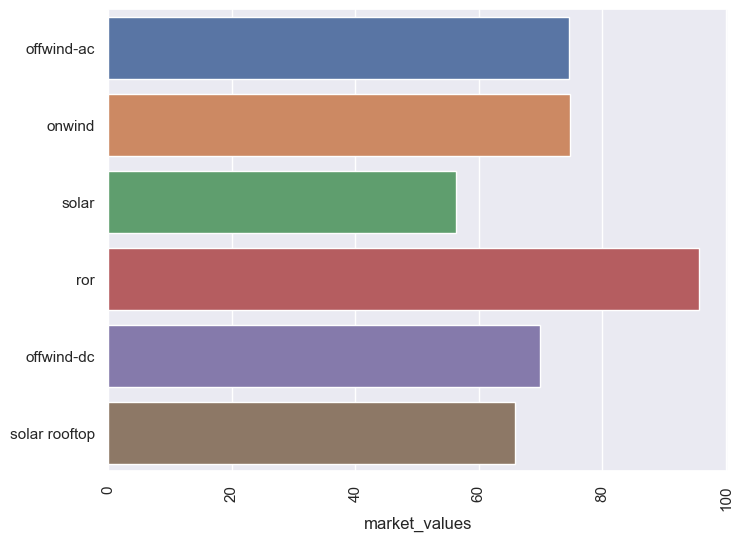

In [146]:
# plot overall market value for all carriers
mv_carriers_mean = pd.DataFrame(mv_carriers.mean())
mv_carriers_mean.columns = ["market_values"]
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(data=mv_carriers_mean,y=mv_carriers_mean.index, x="market_values", orient="h")
ticks = plt.xticks(rotation=90)

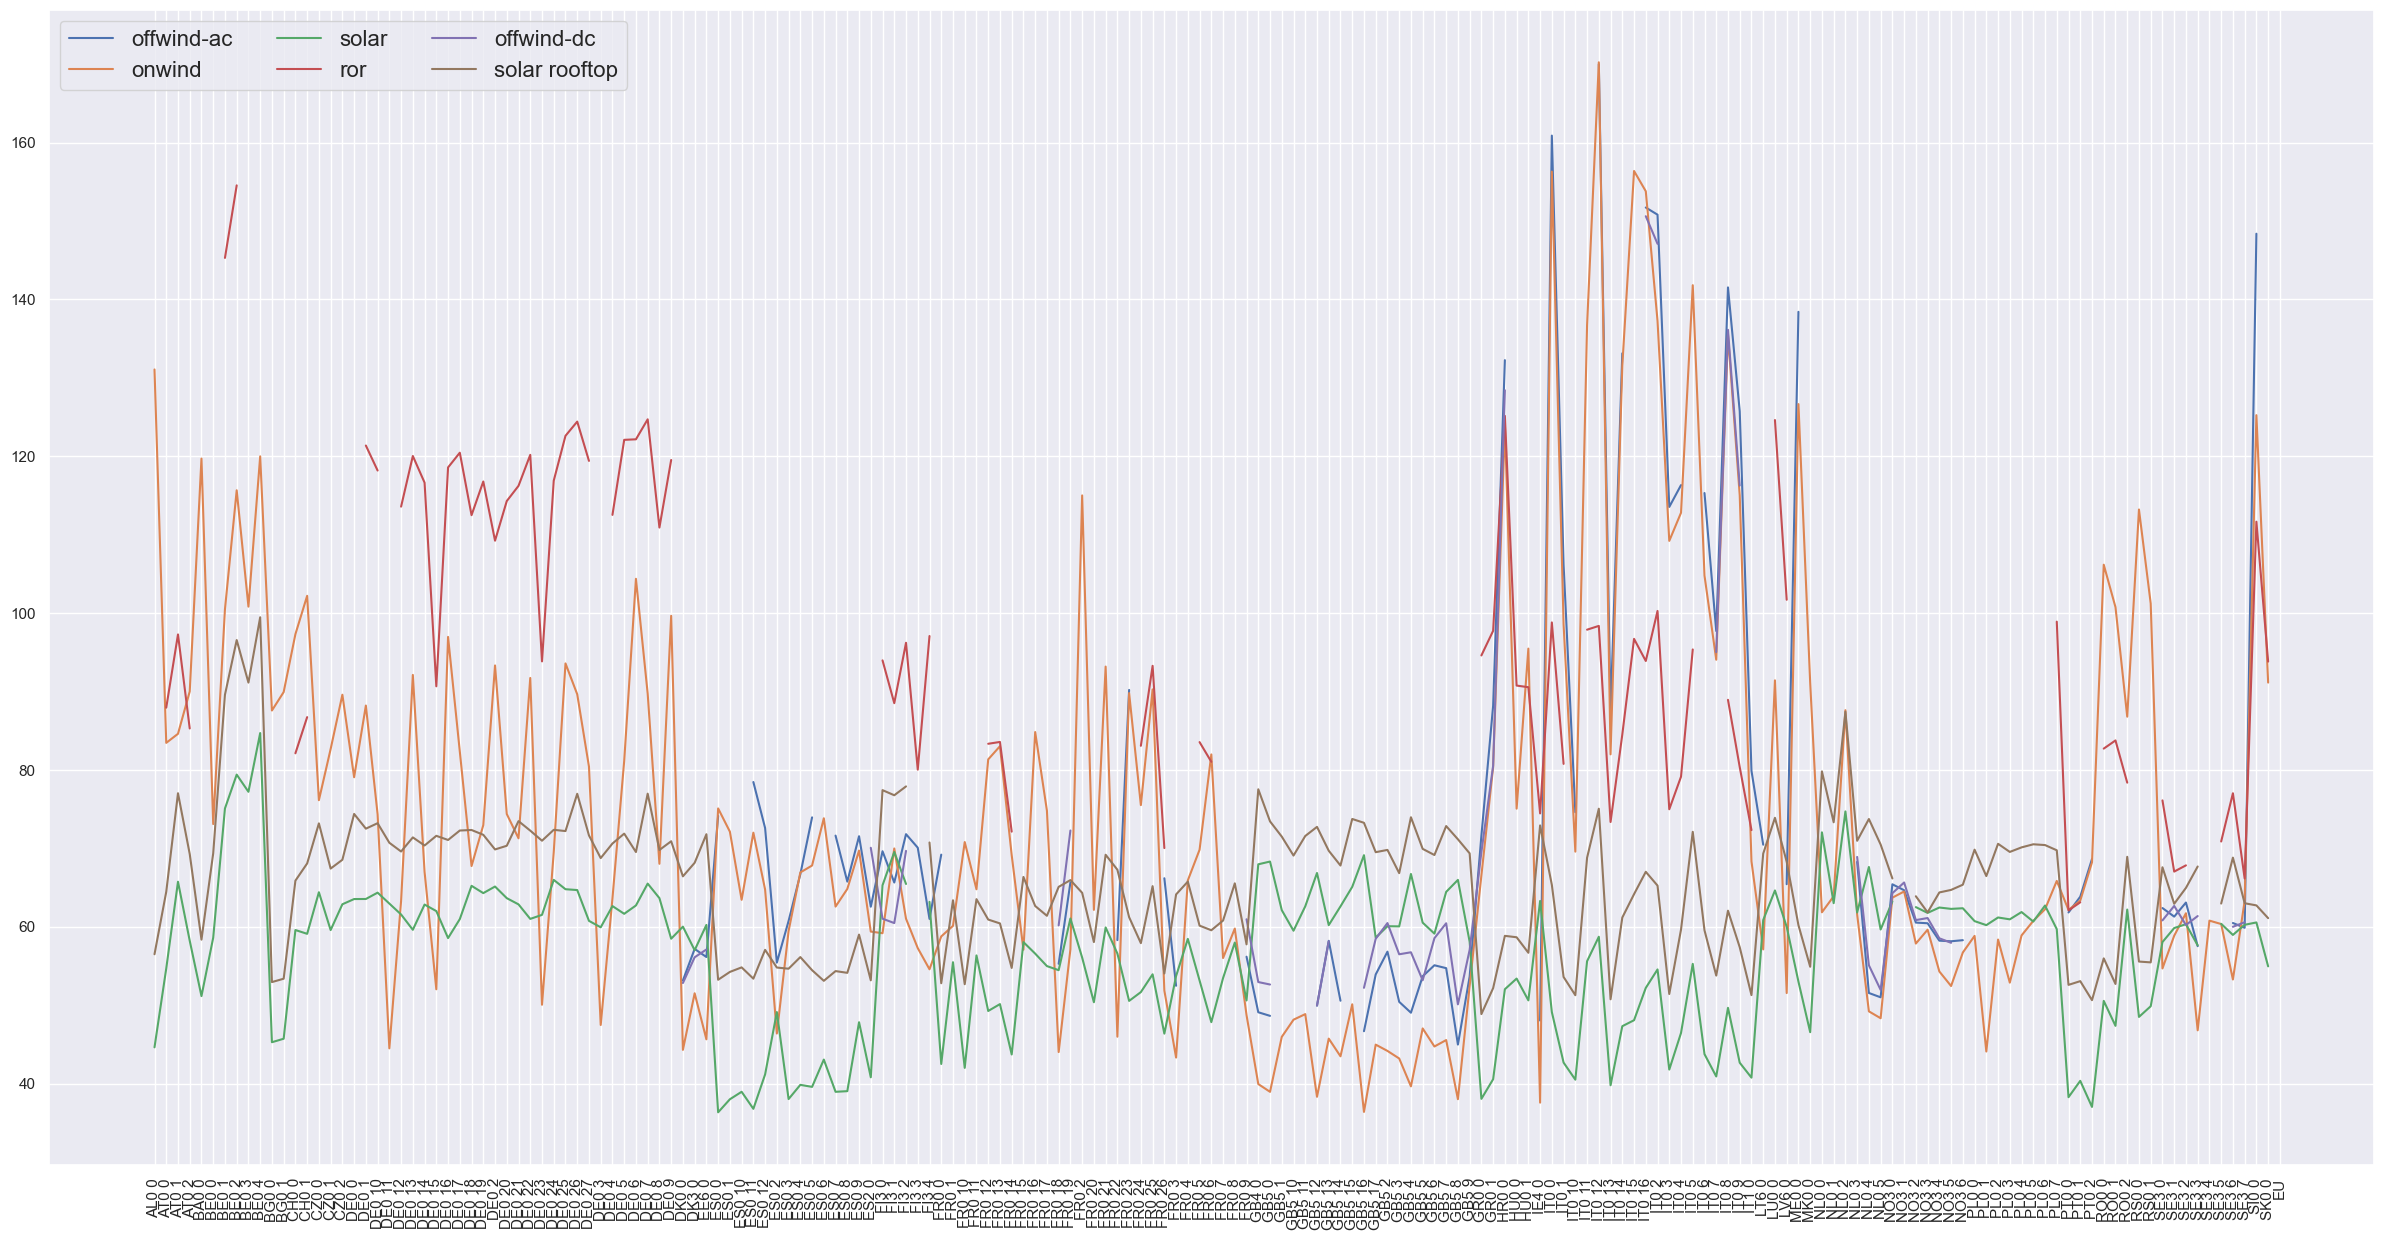

In [147]:
# market value of all carriers for all 181 regions
ax = mv_carriers.plot(figsize=(30,15))
plt.legend(loc='upper left', ncol=3, prop={'size': 16})
ax.set_xticks(range(len(mv_carriers)));
ax.set_xticklabels(labels = [item for item in mv_carriers.index.tolist()], rotation=90);

In [38]:
carrier = "solar rooftop"
# select all the generators for specific carrier e.g. onwind
gen = n.generators_t.p.loc[:, n.generators.carrier == carrier]
# create index from the generators and use as column names
gen.columns = gen.columns.map(n.generators.bus)
# get locational marginal prices for all locations and all time steps
lmp = n.buses_t.marginal_price.loc[:, gen.columns]
# calculate market values as sum product of generation times lmp divided by total generation
mv = (gen * lmp).sum() / gen.sum()
# set location of the buses/nodes as the index -> shape = (n_generators x 1) 1 col with mvs
mv.index = mv.index.map(n.buses.location)

ToDoPlots
- Plot of market values grouped by countries
- Plot of market values of carriers for every time step (is that possible or are these the lmp only then?)
- Plot of lmp